HW-5: Malware Classification (Due 5th January, 2023)
Instructions:

Suppose your company is struggling with a series of computer virus attacks for the past several months. The viruses were grouped into a few types with some effort. However, it takes a long time to sort out what kind of virus it is when been hit with. Thus, as a senior IT department member, you undertook a project to classify the virus as quickly as possible. You've been given a dataset of the features that may be handy (or not), and also the associated virus type (target variable).

You are supposed to try different classification methods and apply best practices we have seen in the lectures such as grid search, cross validation, regularization etc. To increase your grade you can add more elaboration such as using ensembling or exploiting feature selection/extraction techniques. An evaluation rubric is provided.

Please prepare a python notebook that describes the steps, present the results as well as your comments.

You can download the data (csv file) https://drive.google.com/file/d/1yxbibzUU8bjOyChDVFPfQ4viLduYdk29/view?usp=sharing.

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import GenericUnivariateSelect
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline
from matplotlib import pyplot
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [24]:
dataframe = pd.read_csv('malware_classification.csv')

In [25]:
dataframe.head()

,Virtual,Offset,loc,Import,Imports,var,Forwarder,UINT,LONG,BOOL,...,Img99,Img100,Img101,Img102,Img103,Img104,Img105,Img106,Img107,target
0,3.0,3.0,689.0,18.000000,6.0,890.0,6.000000,39.0,17.000000,88.0,...,-208196.847822,149454.443336,330552.774213,133907.410063,44038.800343,55156.067737,-77588.974897,171979.000000,162674.0,2
1,3.0,3.0,583.0,15.000000,5.0,1574.0,8640.382774,6.0,7.000000,30.0,...,36209.864030,221318.549792,-1568.194718,22651.037591,-144906.975987,-33489.566102,157701.356695,7702.000000,6551.0,8
2,3.0,4.0,2796.0,15.000000,5.0,625.0,5.000000,58.0,11.000000,152.0,...,88398.670923,66550.556919,5404.362294,13947.925003,-48559.885445,257023.562444,-204889.973046,151324.169975,12946.0,6
3,3.0,3.0,373.0,2726.071722,9.0,615.0,9.000000,16.0,98583.277889,34.0,...,-157101.258148,-60336.395075,157629.928962,117458.409503,62076.273381,98733.489947,-51461.636374,122247.000000,98621.0,4
4,3.0,3.0,77.0,12.000000,4.0,66.0,91945.635853,3.0,0.000000,5.0,...,32595.648968,-228909.737896,-87033.363460,131606.196188,-118625.690367,89326.297602,-84991.427204,15501.000000,11864.0,1


In [26]:
X = dataframe.drop('target', axis=1)
y = dataframe['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

In [27]:
#lets start with feature selection so that algorithms will run faster(filter method)
mf_select = GenericUnivariateSelect(score_func=mutual_info_classif, mode="k_best", param=20)
mf_select.fit(X_train, y_train)    #fit to the data

X_train = mf_select.transform(X_train)    #transform data to the selected feature space
X_test = mf_select.transform(X_test)    #transform data to the selected feature space

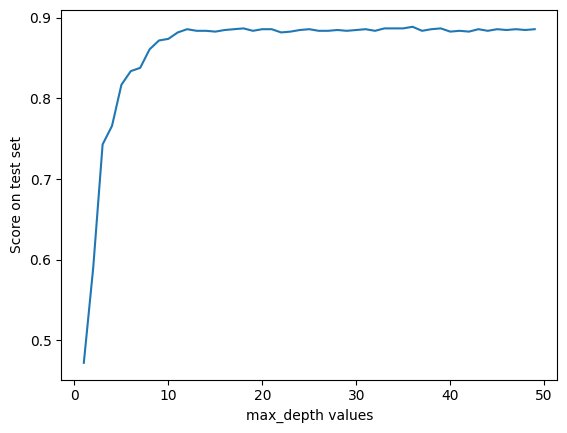

In [28]:
#a little manual feature selection to get a little better results, I did with grid search below too
mdepths = range(1, 50)
scores = np.zeros(len(mdepths))
index=0

for d in mdepths:
    tree_classi = RandomForestClassifier(max_depth=d, min_samples_split=5)
    tree_classi.fit(X_train,y_train)
    u=tree_classi.score(X_test,y_test)
    scores[index]=u
    index+=1

best_option_randomforest = max(scores)
for i in range(len(mdepths)):
    if scores[i] == best_option_randomforest:
        best_option_randomforest = mdepths[i]
        break

pyplot.plot(mdepths, scores)
pyplot.xlabel('max_depth values')
pyplot.ylabel('Score on test set')
pyplot.show()

In [29]:
print(best_option_randomforest)

36


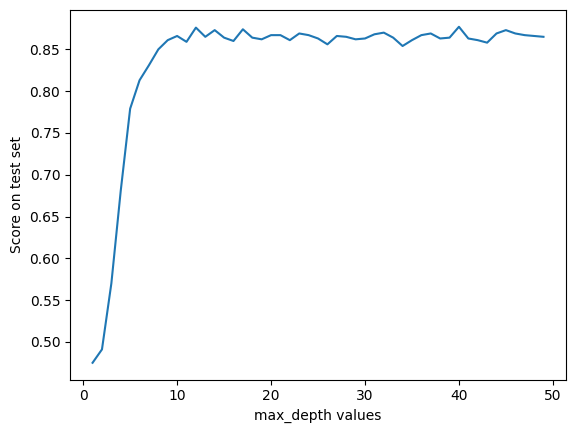

In [30]:
#a little manual feature selection to get a little better results, I did with grid search below too
mdepths = range(1, 50)
scores = np.zeros(len(mdepths))
index=0

for d in mdepths:
    tree_classi = BaggingClassifier(DecisionTreeClassifier(max_depth=d, min_samples_split=5))
    tree_classi.fit(X_train,y_train)
    u=tree_classi.score(X_test,y_test)
    scores[index]=u
    index+=1

best_option_bagging = max(scores)
for i in range(len(mdepths)):
    if scores[i] == best_option_bagging:
        best_option_bagging = mdepths[i]
        break

pyplot.plot(mdepths, scores)
pyplot.xlabel('max_depth values')
pyplot.ylabel('Score on test set')
pyplot.show()

In [31]:
print(best_option_bagging)

40


In [32]:
#Lets add some options. 
#First, lets vote among all 3 model types
#ensembling with bagging and random forest.
classifiers = []
names = []
best_scores = []


classifiers.append( VotingClassifier([ (str(x), DecisionTreeClassifier() ) for x in range(20) ]) )
names.append("Vote(DTx20)")
classifiers.append( VotingClassifier([ (str(x), LogisticRegression(solver='liblinear', multi_class='auto') ) for x in range(20)  ]) )
names.append("Vote(LRx20)")
classifiers.append( VotingClassifier([ (str(x), KNeighborsClassifier() ) for x in range(20) ]) )
names.append("Vote(NNx20)")

classifiers.append( BaggingClassifier(DecisionTreeClassifier(), n_estimators=best_option_bagging, max_samples=0.6) )
names.append("Bag(DTx20)")
classifiers.append( BaggingClassifier(LogisticRegression(solver='liblinear', multi_class='auto'), n_estimators=best_option_bagging, max_samples=0.6) )
names.append("Bag(LRx20)")
classifiers.append( BaggingClassifier(KNeighborsClassifier(), n_estimators=best_option_bagging, max_samples=0.6) )
names.append("Bag(NNx20)")

classifiers.append(RandomForestClassifier(n_estimators=100))
names.append("Random Forest")


for model, m_name in zip(classifiers, names):
  model.fit(X_train, y_train)
  print(m_name,'score: ', accuracy_score(y_test, model.predict(X_test)))
  best_scores.append(accuracy_score(y_test, model.predict(X_test)))
  scores = cross_val_score(model, X_train, y_train, cv=5)
  print('Cross validation scores: ', scores)
randomforest = classifiers[6]
baggingdecisiontree=classifiers[3]

Vote(DTx20) score:  0.782
Cross validation scores:  [0.77875    0.77875    0.78875    0.78       0.78222778]
Vote(LRx20) score:  0.426
Cross validation scores:  [0.42875    0.41375    0.40625    0.41125    0.40801001]
Vote(NNx20) score:  0.775
Cross validation scores:  [0.76875    0.7475     0.75875    0.775      0.76846058]
Bag(DTx20) score:  0.874
Cross validation scores:  [0.8625    0.8725    0.865     0.8625    0.8660826]
Bag(LRx20) score:  0.423
Cross validation scores:  [0.43       0.4075     0.40375    0.415      0.40801001]
Bag(NNx20) score:  0.764
Cross validation scores:  [0.7675    0.755     0.7625    0.7725    0.7747184]
Random Forest score:  0.886
Cross validation scores:  [0.87625    0.89125    0.87375    0.87625    0.87984981]


We will check RandomForestClassifier and BaggingClassifier(DecisionTreeClassifier().

In [34]:
#hyperparameter search for random forest


param_grid = {
    'classifier__min_samples_leaf': [1,2,3],
    'classifier__min_samples_split': [2,3,4,5],
    'classifier__max_features': ['sqrt', 'log2', None],
    'classifier__criterion':['gini', 'entropy','log_loss']
}

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', randomforest)
])


grid_search_randomforest= GridSearchCV(estimator = pipeline, param_grid = param_grid, 
                           cv = 3, n_jobs = -1, verbose = 2)


grid_search_randomforest.fit(X_train, y_train)

print(grid_search_randomforest.best_params_)
print(grid_search_randomforest.best_score_)
#I tried too much parameters to get better results but it didn't work very well. 

Fitting 3 folds for each of 108 candidates, totalling 324 fits
{'classifier__criterion': 'log_loss', 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 3}
0.8797199299824957


In [35]:
#hyperparameter search for bagging(decision tree)

param_grid = {'n_estimators': [10, 20, 30],
              'max_samples': [0.5, 0.7, 1.0],
              'max_features': [0.5, 0.7, 1.0]}

grid_search = GridSearchCV(estimator=baggingdecisiontree, param_grid=param_grid, cv=5)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

test_score = grid_search.score(X_test, y_test)

print(test_score)
#tuning seems to be working well.

{'max_features': 0.5, 'max_samples': 1.0, 'n_estimators': 30}
0.879
